<a href="https://colab.research.google.com/github/ThinkingBeyond/BeyondQuantum-2025/blob/main/beyondquantum_lucasrhode_kishanbhowal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
# Install Qiskit and required dependencies
!pip uninstall -y -q spacy thinc
!pip install -q "qiskit==0.46.0" "qiskit-aer==0.13.3" numpy==1.26.4 matplotlib tqdm pandas


# Import Libraries

In [ ]:
import time
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator  # For running quantum simulations
from qiskit.quantum_info import partial_trace, entropy  # For entropy and tracing out qubits
from qiskit.providers.aer.library import SaveMatrixProductState  # Save MPS snapshots

# ── extra gates / circuits used later ───────────────────────────────────
from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate

warnings.filterwarnings("ignore")  # Hide warning messages during execution
print("Libraries loaded.")


Libraries loaded.


<ipython-input-2-5cb351b88256>:10: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer import AerSimulator  # For running quantum simulations
<ipython-input-2-5cb351b88256>:12: DeprecationWarning: Importing from 'qiskit.providers.aer' is deprecated. Import from 'qiskit_aer' instead, which should work identically.
  from qiskit.providers.aer.library import SaveMatrixProductState  # Save MPS snapshots
<ipython-input-2-5cb351b88256>:16: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


# Grover's Circuit Construction

In [ ]:
def int2bits(i: int, n: int) -> str:
    """Convert integer to n-bit binary string."""
    return format(i, f"0{n}b")

def grover_oracle(n: int, marked: int) -> QuantumCircuit:
    """Create the Grover oracle circuit for the marked item."""
    qc = QuantumCircuit(n, name="Oracle")
    bits = int2bits(marked, n)[::-1]   # LSBit is qubit 0
    for q, b in enumerate(bits):
        if b == "0":
            qc.x(q)
    if n > 0:
        if n == 1:
            qc.z(0)  # Special case for 1-qubit oracle
        else:
            qc.h(n - 1)
            qc.mcx(list(range(n - 1)), n - 1)
            qc.h(n - 1)
    for q, b in enumerate(bits):
        if b == "0":
            qc.x(q)
    return qc

def diffusion_operator(n: int) -> QuantumCircuit:
    """Construct the diffusion operator used in Grover's search."""
    qc = QuantumCircuit(n, name="Diffusion")
    qc.h(range(n))
    qc.x(range(n))
    if n > 0:
        if n == 1:
            qc.z(0)  # Simple Z gate for 1-qubit case
        else:
            qc.h(n - 1)
            qc.mcx(list(range(n - 1)), n - 1)
            qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

def build_grover_iterations(n: int, marked: int, iterations: int,
                            save_intermediate_states: bool = False,
                            save_final_mps: bool = False) -> QuantumCircuit:
    """Assemble the Grover circuit"""
    qc = QuantumCircuit(n)
    if n == 0:
        return qc

    qc.h(range(n))   # Begin with Hadamards

    if iterations > 0:
        oracle_gate = grover_oracle(n, marked).to_gate()
        diffusion_gate = diffusion_operator(n).to_gate()

        for k in range(iterations):
            qc.append(oracle_gate, range(n))
            qc.append(diffusion_gate, range(n))
            if save_intermediate_states:
                qc.save_statevector(label=f"psi_{k+1}")

    if save_final_mps:
        qc.append(SaveMatrixProductState(n, label="final_mps_data"), qc.qubits)

    return qc


#  Experiment Configuration

In [ ]:
# Define experiment parameters
n_list = [4, 6, 8, 10, 12]    # Number of qubits to simulate
marked_state = 0              # We'll search for the |0...0⟩ state
cut_strategy = "half"         # How to cut qubits for entropy: "half" or "single"


# Backend Setup

In [ ]:
# Choose simulation backends
statevec_sim = AerSimulator(method="statevector")              # Full state vector
mps_sim = AerSimulator(method="matrix_product_state")          # Matrix product state (MPS)


# Run Simulations and Collect Results

In [ ]:
# Loop through different qubit counts and simulate Grover's algorithm
results = {
    n: {
        "entropy_trace": [],
        "peak_entropy": None,
        "mps_time": None,
        "iterations": None,
        "peak_bond_dimension": None,
        "theoretical_bond_dimension": None
    } for n in n_list
}

print("Starting simulations...\n")

for n in tqdm(n_list, desc="Qubit sizes"):
    optimal_iters = int(round(math.pi / 4 * math.sqrt(2**n)))
    if n <= 2 and optimal_iters == 0:
        optimal_iters = 1

    results[n]["iterations"] = optimal_iters

    # ----- Statevector Simulation -----
    ent_list = []
    grover_entropy = build_grover_iterations(n, marked_state, optimal_iters,
                                             save_intermediate_states=True,
                                             save_final_mps=False)

    if optimal_iters > 0 and any(not instr.operation.name.startswith("save_statevector") for instr in grover_entropy.data):
        sv_job = statevec_sim.run(transpile(grover_entropy, statevec_sim))
        sv_result = sv_job.result()

        for k in range(optimal_iters):
            label = f"psi_{k+1}"
            if label not in sv_result.data():
                print(f"Warning: {label} missing for n={n}")
                continue

            state = sv_result.data()[label]
            if cut_strategy == "half":
                A = list(range(n // 2))
            elif cut_strategy == "single":
                A = [0] if n > 0 else []
            else:
                raise ValueError("cut_strategy must be 'half' or 'single'")

            if not A or len(A) == n:
                ent = 0.0
            else:
                reduced = partial_trace(state, A)
                ent = entropy(reduced, base=2)

            ent_list.append(ent)

    results[n]["entropy_trace"] = ent_list
    results[n]["peak_entropy"] = max(ent_list) if ent_list else 0.0
    results[n]["theoretical_bond_dimension"] = 2**results[n]["peak_entropy"] if results[n]["peak_entropy"] > 1e-9 else 1.0

    # ----- MPS Simulation -----
    grover_mps = build_grover_iterations(n, marked_state, optimal_iters,
                                         save_intermediate_states=False,
                                         save_final_mps=True)

    has_ops = any(not instr.operation.name.startswith("save_matrix_product_state") for instr in grover_mps.data)
    has_save = any(instr.operation.name == "save_matrix_product_state" for instr in grover_mps.data)

    if has_ops or has_save:
        t0 = time.perf_counter()
        job = mps_sim.run(transpile(grover_mps, mps_sim), mps_log_data=True)
        result = job.result()
        results[n]["mps_time"] = time.perf_counter() - t0

        peak_bond = None
        try:
            data = result.data(transpile(grover_mps, mps_sim))
            mps = data.get("final_mps_data")

            if isinstance(mps, tuple) and len(mps) == 2:
                lambdas = mps[1]
                if isinstance(lambdas, list):
                    if n == 1:
                        peak_bond = 1.0
                    elif len(lambdas) == n - 1:
                        dims = [len(vec) for vec in lambdas if isinstance(vec, (list, np.ndarray))]
                        peak_bond = float(max(dims)) if dims else None

        except Exception as e:
            print(f"Error parsing MPS data for n={n}: {e}")

        results[n]["peak_bond_dimension"] = peak_bond or results[n]["theoretical_bond_dimension"]
    else:
        results[n]["mps_time"] = 0.0
        results[n]["peak_bond_dimension"] = results[n]["theoretical_bond_dimension"]

print("\nSimulations complete.\n")


Starting simulations...



Qubit sizes:   0%|          | 0/5 [00:00<?, ?it/s]


Simulations complete.



# Visualization – Entropy, Runtime, and Bond Dimension

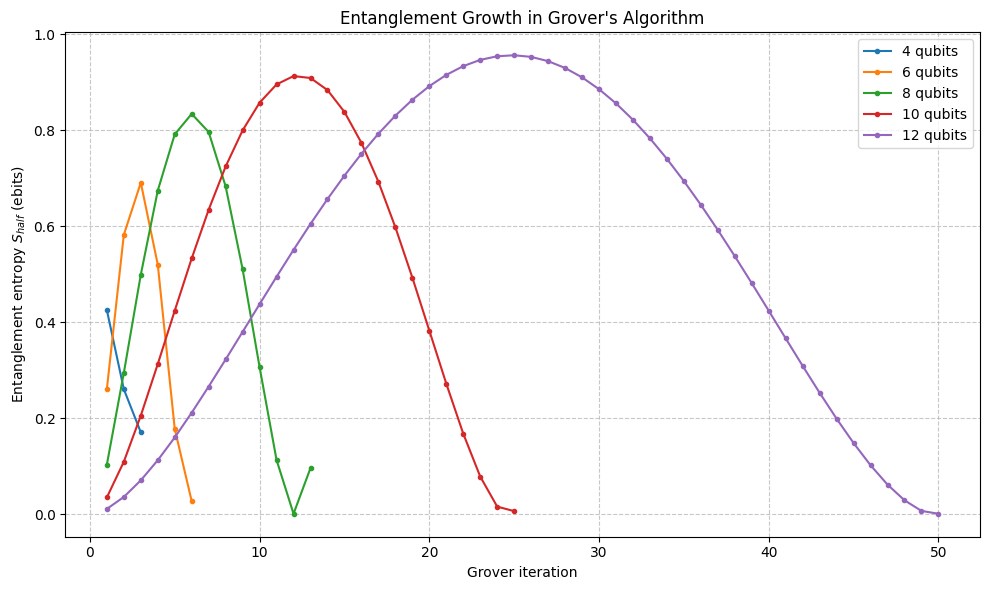

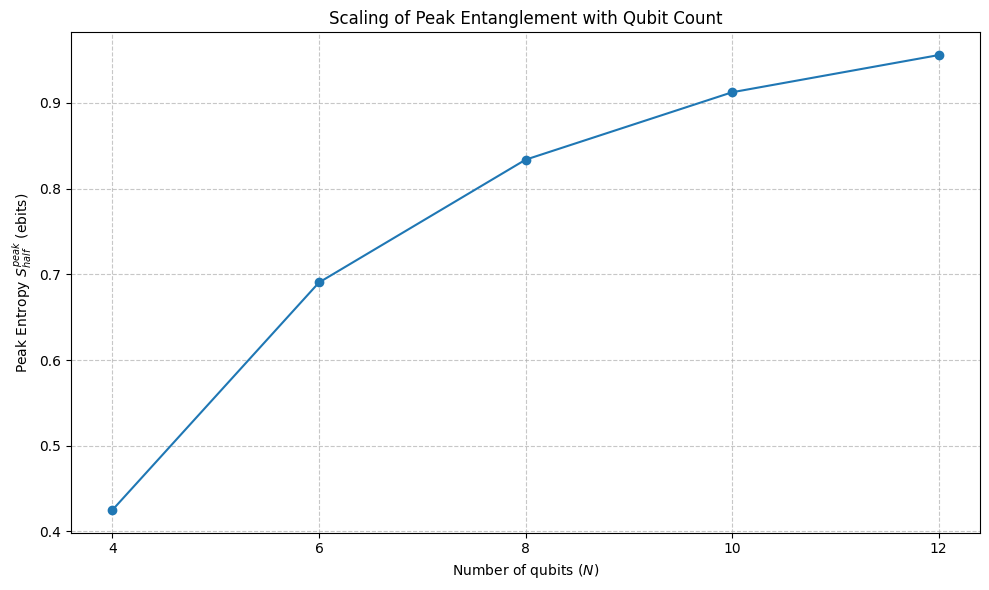

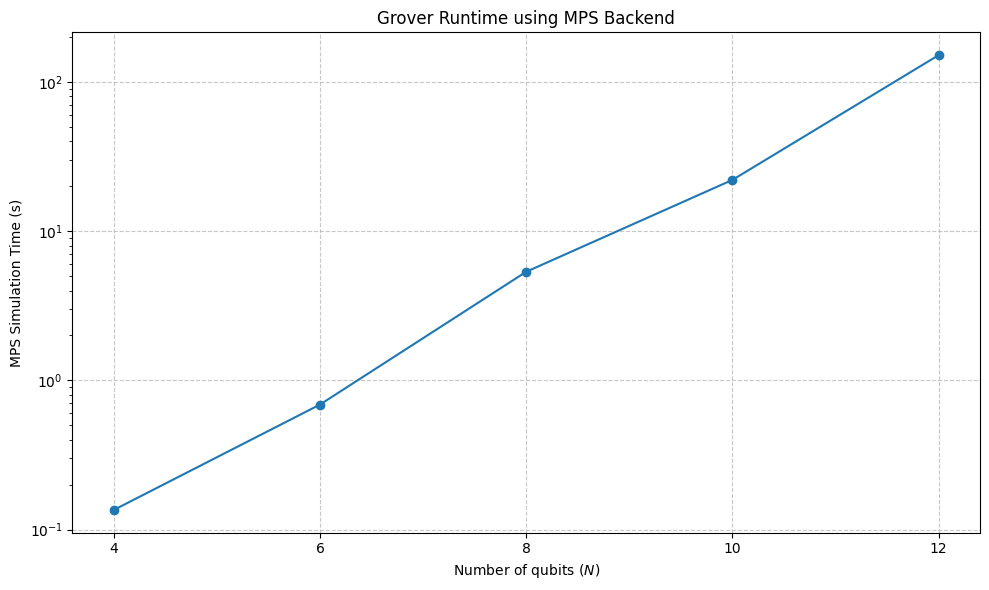

In [ ]:
# Plot how entanglement evolves during Grover iterations
plt.figure(figsize=(10, 6))
for n_qubits in n_list:
    trace = results[n_qubits]["entropy_trace"]
    if trace:
        xs = np.arange(1, len(trace) + 1)
        plt.plot(xs, trace, label=f"{n_qubits} qubits", marker='.')
plt.xlabel("Grover iteration")
plt.ylabel(f"Entanglement entropy $S_{{{cut_strategy}}}$ (ebits)")
plt.title("Entanglement Growth in Grover's Algorithm")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot max entropy vs. number of qubits
plt.figure(figsize=(10, 6))
peak_ent = [results[n]["peak_entropy"] for n in n_list]
plt.plot(n_list, peak_ent, marker="o")
plt.xlabel("Number of qubits ($N$)")
plt.ylabel(f"Peak Entropy $S_{{{cut_strategy}}}^{{peak}}$ (ebits)")
plt.title("Scaling of Peak Entanglement with Qubit Count")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(n_list)
plt.tight_layout()
plt.show()

# MPS runtime vs. number of qubits (log scale)
plt.figure(figsize=(10, 6))
mps_times = [results[n]["mps_time"] for n in n_list]
plt.plot(n_list, mps_times, marker="o")
plt.xlabel("Number of qubits ($N$)")
plt.ylabel("MPS Simulation Time (s)")
plt.title("Grover Runtime using MPS Backend")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(n_list)
plt.tight_layout()
plt.show()


# Scaling Trends and Bond Dimension

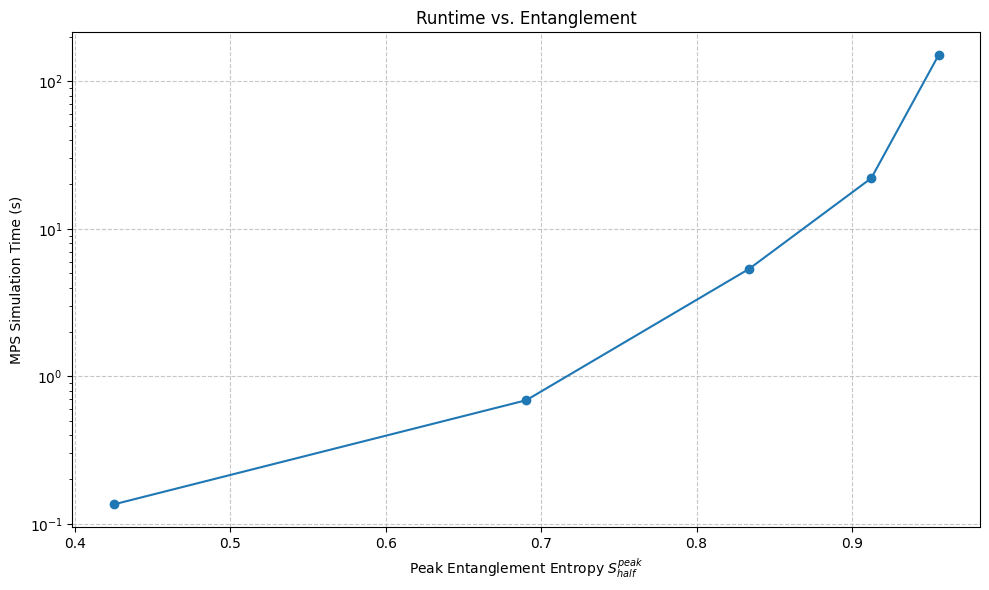

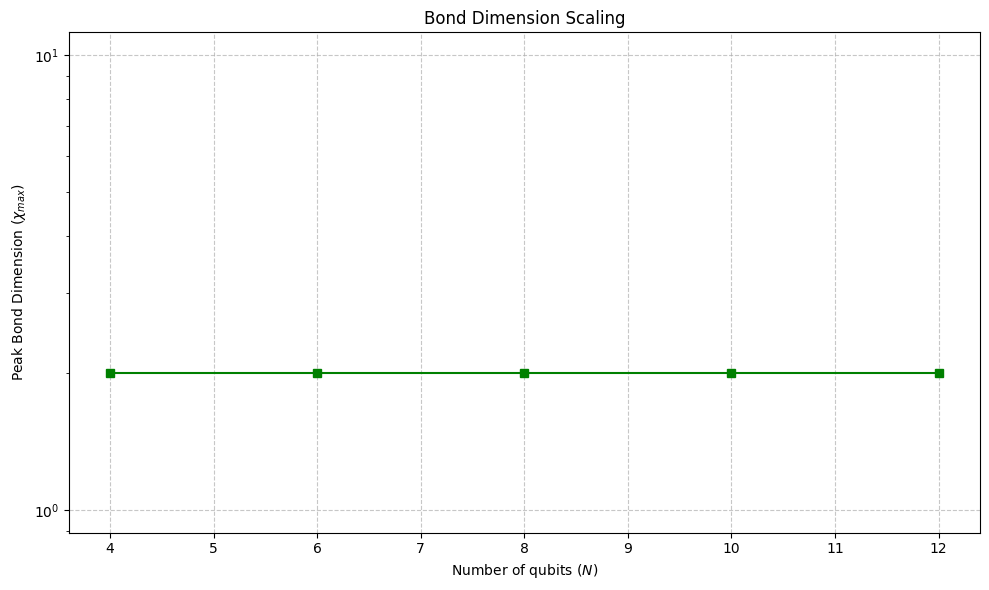

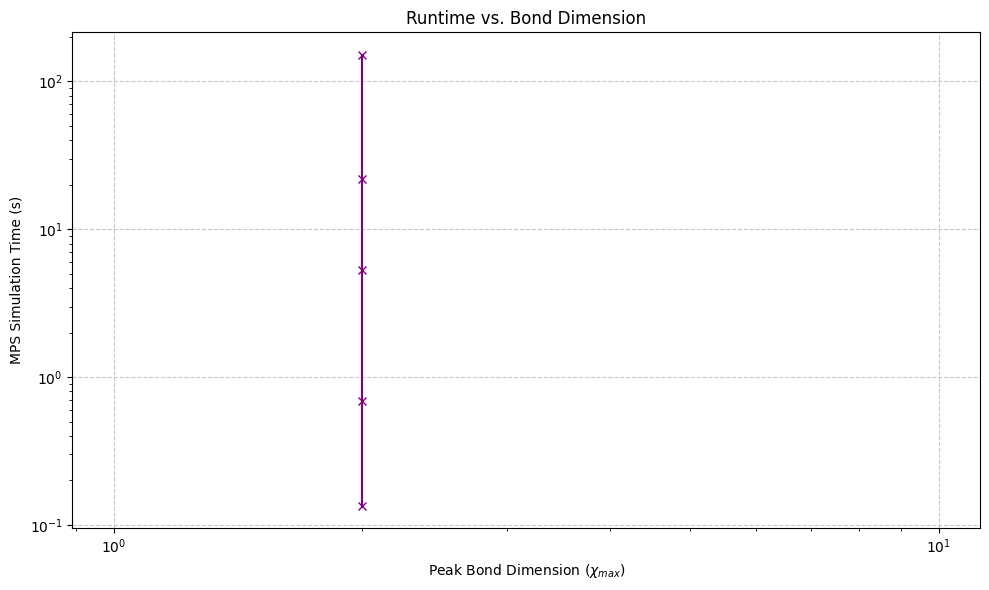

In [ ]:
# Time vs. Entropy
plt.figure(figsize=(10, 6))
valid_n = [n for n in n_list if results[n]["peak_entropy"] > 1e-9]
entropy_vals = [results[n]["peak_entropy"] for n in valid_n]
time_vals = [results[n]["mps_time"] for n in valid_n]
if entropy_vals and time_vals:
    plt.plot(entropy_vals, time_vals, marker="o")
    plt.xlabel(f"Peak Entanglement Entropy $S_{{{cut_strategy}}}^{{peak}}$")
    plt.ylabel("MPS Simulation Time (s)")
    plt.title("Runtime vs. Entanglement")
    plt.yscale("log")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Missing entropy data for runtime vs. entropy plot.")

# Bond dimension vs. qubits
plt.figure(figsize=(10, 6))
bd_vals = [results[n]["peak_bond_dimension"] for n in n_list if results[n]["peak_bond_dimension"]]
bd_n = [n for n in n_list if results[n]["peak_bond_dimension"]]
if bd_vals:
    plt.plot(bd_n, bd_vals, marker="s", color="green")
    plt.xlabel("Number of qubits ($N$)")
    plt.ylabel("Peak Bond Dimension ($\\chi_{max}$)")
    plt.title("Bond Dimension Scaling")
    plt.yscale("log")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No bond dimension data to plot.")

# Runtime vs. bond dimension
plt.figure(figsize=(10, 6))
times = []
bds = []
for n in n_list:
    t = results[n]["mps_time"]
    bd = results[n]["peak_bond_dimension"]
    if t and bd and bd > 0:
        times.append(t)
        bds.append(bd)
if times and bds:
    sorted_bd_time = sorted(zip(bds, times))
    sorted_bds, sorted_times = zip(*sorted_bd_time)
    plt.plot(sorted_bds, sorted_times, marker="x", color="purple")
    plt.xlabel("Peak Bond Dimension ($\\chi_{max}$)")
    plt.ylabel("MPS Simulation Time (s)")
    plt.title("Runtime vs. Bond Dimension")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Missing bond dimension or timing data.")


# Entropy vs. log₂(Bond Dimension)

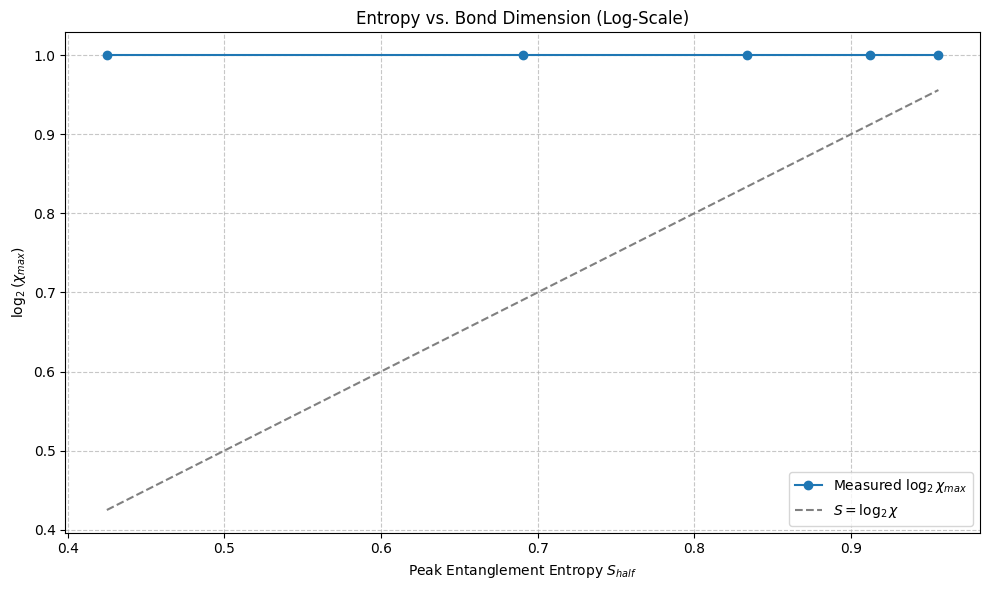

In [ ]:
# Entropy vs. log2(actual bond dimension)
plt.figure(figsize=(10, 6))
ent_vals = []
actual_bd_log2 = []

for n in n_list:
    S = results[n]["peak_entropy"]
    chi = results[n]["peak_bond_dimension"]
    if S and chi and S > 1e-9 and chi > 0:
        ent_vals.append(S)
        actual_bd_log2.append(math.log2(chi))

if ent_vals and actual_bd_log2:
    plt.plot(ent_vals, actual_bd_log2, marker="o", label="Measured $\\log_2 \\chi_{max}$")
    min_s = min(ent_vals)
    max_s = max(ent_vals)
    plt.plot([min_s, max_s], [min_s, max_s], linestyle="--", color="gray", label="$S = \\log_2 \\chi$")
    plt.xlabel(f"Peak Entanglement Entropy $S_{{{cut_strategy}}}$")
    plt.ylabel("$\\log_2(\\chi_{max})$")
    plt.title("Entropy vs. Bond Dimension (Log-Scale)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough valid entropy/bond dimension pairs for plot.")


# Inspect Raw Results

In [ ]:
# Summary table + background notes
import pandas as pd
from math import pow

summary_rows = []
for n in n_list:
    S_peak  = results[n].get("peak_entropy")
    chi_actual = None # Initialize chi_actual to None or some default
    if "peak_bond_dimension" in results[n] and results[n]["peak_bond_dimension"] is not None:
        chi_actual = results[n]["peak_bond_dimension"]
    chi_theory = None if S_peak is None else pow(2, S_peak)

    summary_rows.append({
        "n_qubits":            n,
        "iterations":          results[n]["iterations"],
        "S_max  (ebits)":      f"{S_peak:.4f}" if S_peak is not None else "N/A",
        "χ_max  (actual)":     f"{chi_actual:.1f}" if chi_actual is not None else "N/A",
        "χ_max  theory (2^S)": f"{chi_theory:.1f}" if chi_theory is not None else "N/A",
        "MPS time  (s)":       f"{results[n]['mps_time']:.4f}" if results[n]['mps_time'] is not None else "N/A",
    })

summary_df = pd.DataFrame(summary_rows)
print("\n--- Summary Table ---")
print(summary_df.to_string(index=False))

# ── Extra context ─────────────────────
print("\n\n--- Theoretical Background for MPS Cost ---")
print("The classical simulation cost of an MPS scales with the *maximum* "
      "bond dimension χ_max encountered during the circuit evolution.")
print("For a 1-D chain, χ_max is lower-bounded by 2^S_max, where S_max is the "
      "largest bipartite entanglement entropy (in ebits) across any cut.")
print("Thus, a crude cost model is  T ∼ poly(N) · χ_max^k  (k ≈ 2–3 for typical "
      "dense-gate circuits).  Substituting χ_max ≳ 2^S_max gives\n"
      "      T ∼ poly(N) · 2^{k · S_max}.")

if cut_strategy == "single":
    print("\nNote: With the 'single'-qubit cut the measured entropy can "
          "underestimate the true χ_max that limits bulk MPS simulations. "
          "The 'half'-cut is usually the more diagnostic choice.")

print("\n--- Notes on χ_max extraction ---")
print("χ_max (actual) is taken directly from Qiskit Aer's "
      "`save_matrix_product_state` snapshot.  If you ever see 'N/A', "
      "inspect `snapshot.keys()` to adapt the parsing logic to a future "
      "Aer version.")



--- Summary Table ---
 n_qubits  iterations S_max  (ebits) χ_max  (actual) χ_max  theory (2^S) MPS time  (s)
        4           3         0.4250             2.0                 1.3        0.1353
        6           6         0.6905             2.0                 1.6        0.6882
        8          13         0.8337             2.0                 1.8        5.3440
       10          25         0.9124             2.0                 1.9       22.0588
       12          50         0.9558             2.0                 1.9      151.3528


--- Theoretical Background for MPS Cost ---
The classical simulation cost of an MPS scales with the *maximum* bond dimension χ_max encountered during the circuit evolution.
For a 1-D chain, χ_max is lower-bounded by 2^S_max, where S_max is the largest bipartite entanglement entropy (in ebits) across any cut.
Thus, a crude cost model is  T ∼ poly(N) · χ_max^k  (k ≈ 2–3 for typical dense-gate circuits).  Substituting χ_max ≳ 2^S_max gives
      T ∼ po

# Input Validation

In [ ]:
# Check that the bitstring only contains 0s and 1s
def _validate_bitstring(secret: str, param_name: str = "secret") -> None:
    if not secret or any(b not in "01" for b in secret):
        raise ValueError(f"{param_name} must be a non-empty string of 0s and 1s.")


# Bernstein–Vazirani Circuit

In [ ]:
# Create the Bernstein–Vazirani oracle for a given secret bitstring
def bernstein_vazirani_circuit(secret: str) -> QuantumCircuit:
    _validate_bitstring(secret)
    n = len(secret)
    qc = QuantumCircuit(n + 1, name=f"BV_{n}")

    aux = n
    qc.x(aux)
    qc.h(aux)

    qc.h(range(n))
    for i, bit in enumerate(reversed(secret)):  # bitstring is LSB -> qubit 0
        if bit == "1":
            qc.cx(i, aux)

    qc.h(range(n))
    qc.barrier(label="BV done")
    return qc


# Deutsch–Jozsa Circuit

In [ ]:
# Build the Deutsch–Jozsa circuit with selectable built-in oracles
def deutsch_jozsa_circuit(n: int, oracle: str = "balanced_parity") -> QuantumCircuit:
    if n < 1:
        raise ValueError("Need at least one input qubit for Deutsch–Jozsa.")

    supported_oracles = {
        "constant_zero",
        "constant_one",
        "balanced_first_bit",
        "balanced_parity"
    }
    if oracle not in supported_oracles:
        raise ValueError(f"Unknown oracle type: {oracle}")

    qc = QuantumCircuit(n + 1, name=f"DJ_{oracle}_n{n}")
    aux = n

    qc.x(aux)
    qc.h(aux)
    qc.h(range(n))

    # Apply oracle based on the selected type
    if oracle == "constant_one":
        qc.x(aux)
    elif oracle == "balanced_first_bit":
        qc.cx(0, aux)
    elif oracle == "balanced_parity":
        for i in range(n):
            qc.cx(i, aux)

    qc.h(range(n))
    qc.barrier(label="DJ done")
    return qc


# QFT and iQFT Circuits

In [ ]:
def qft_circuit(n: int, do_swaps: bool = True) -> QuantumCircuit:
    """Forward Quantum Fourier Transform (QFT) on n qubits."""
    if n < 0:
        raise ValueError("Number of qubits must be non-negative.")
    return QFT(n, do_swaps=do_swaps).decompose()

def iqft_circuit(n: int, do_swaps: bool = True) -> QuantumCircuit:
    """Inverse QFT (used in Phase Estimation)."""
    return QFT(n, do_swaps=do_swaps, inverse=True).decompose()


# Phase Estimation Circuit


In [ ]:
def phase_estimation_circuit(n_count: int, unitary: QuantumCircuit, eigen_prep: QuantumCircuit | None = None) -> QuantumCircuit:
    """Construct the standard textbook QPE circuit with controlled-U^{2^k}."""
    if n_count < 1:
        raise ValueError("Must have at least one counting qubit.")

    m = unitary.num_qubits
    total = n_count + m
    qc = QuantumCircuit(total, name=f"QPE_{n_count}_{m}")
    count = range(n_count)
    target = range(n_count, total)

    if eigen_prep:
        if eigen_prep.num_qubits != m:
            raise ValueError("Mismatch in number of qubits for eigenstate prep.")
        qc.compose(eigen_prep, target, inplace=True)

    qc.h(count)
    base_gate = UnitaryGate(unitary.to_matrix(), label="U")
    for k in range(n_count):
        qc.append(base_gate.power(1 << k).control(), [count[k], *target])

    qc.append(iqft_circuit(n_count), count)
    qc.barrier(label="QPE done")
    return qc


# QAOA for Max-Cut

In [ ]:
from typing import Sequence, Tuple

def qaoa_maxcut_circuit(
    edges: Sequence[Tuple[int, int]],
    p: int,
    gammas: Sequence[float],
    betas: Sequence[float],
) -> QuantumCircuit:
    """QAOA-p for Max-Cut on an undirected graph."""
    if p < 1:
        raise ValueError("p must be at least 1.")
    if len(gammas) != p or len(betas) != p:
        raise ValueError("gammas and betas must be length-p sequences.")

    n = max((max(u, v) for u, v in edges), default=-1) + 1
    qc = QuantumCircuit(n, name=f"QAOA_MaxCut_n{n}_p{p}")

    qc.h(range(n))
    for k in range(p):
        # cost Hamiltonian
        for u, v in edges:
            qc.rzz(2 * gammas[k], u, v)
        # mixer
        qc.rx(2 * betas[k], range(n))

    qc.barrier(label="QAOA done")
    return qc


# Ising Model Trotterization

In [ ]:
def trotter_ising_circuit(n: int, J: float, h: float, t: float, steps: int, init: str = "+") -> QuantumCircuit:
    """Trotterized simulation of Ising model with open boundaries."""
    if n < 1:
        raise ValueError("Need at least one spin.")
    if steps < 1:
        raise ValueError("Number of Trotter steps must be ≥1.")
    if init not in {"0", "+"}:
        raise ValueError("Initial state must be '0' or '+'.")

    dt = t / steps
    qc = QuantumCircuit(n, name=f"Ising_n{n}_t{t}_s{steps}")

    if init == "+":
        qc.h(range(n))

    for _ in range(steps):
        for i in range(n - 1):
            qc.cx(i, i + 1)
            qc.rz(-2 * J * dt, i + 1)
            qc.cx(i, i + 1)
        qc.rx(-2 * h * dt, range(n))

    qc.barrier(label="Ising done")
    return qc

print("Extra algorithms loaded: BV, DJ, QFT, QPE, QAOA, Ising")


Extra algorithms loaded: BV, DJ, QFT, QPE, QAOA, Ising


# Benchmarking and Visualization


▶ grover
  N= 4  χ=2   S=0.170  t=0.0537s
  N= 6  χ=2   S=0.027  t=0.411s
  N= 8  χ=2   S=0.096  t=2.07s
  N=10  χ=2   S=0.006  t=17.5s
  N=12  χ=2   S=0.001  t=154s

▶ bernstein_vazirani
  N= 4  χ=1   S=0.000  t=0.163s
  N= 6  χ=1   S=0.000  t=0.284s
  N= 8  χ=1   S=0.000  t=0.0128s
  N=10  χ=1   S=0.000  t=0.0117s
  N=12  χ=1   S=0.000  t=0.0138s

▶ deutsch_jozsa
  N= 4  χ=1   S=0.000  t=0.0138s
  N= 6  χ=1   S=0.000  t=0.011s
  N= 8  χ=1   S=0.000  t=0.011s
  N=10  χ=1   S=0.000  t=0.0153s
  N=12  χ=1   S=0.000  t=0.0124s

▶ qft
  N= 4  χ=1   S=-0.000  t=0.0111s
  N= 6  χ=1   S=-0.000  t=0.0149s
  N= 8  χ=1   S=-0.000  t=0.0148s
  N=10  χ=1   S=-0.000  t=0.0143s
  N=12  χ=1   S=-0.000  t=0.0198s

▶ phase_est
  N= 4  χ=4   S=0.548  t=0.0207s
  N= 6  χ=4   S=0.548  t=0.0208s
  N= 8  χ=4   S=0.548  t=0.0218s
  N=10  χ=4   S=0.548  t=0.0189s
  N=12  χ=4   S=0.548  t=0.0224s

▶ qaoa
  N= 4  χ=4   S=1.999  t=0.014s
  N= 6  χ=4   S=1.999  t=0.0213s
  N= 8  χ=4   S=1.999  t=0.0185s
  N=10 

,alg,N,runtime,S_peak,chi_max
0,grover,4,0.053746,1.703655e-01,2
1,grover,6,0.411161,2.686844e-02,2
2,grover,8,2.068374,9.600808e-02,2
3,grover,10,17.492032,6.278797e-03,2
4,grover,12,153.612183,8.290289e-04,2
5,bernstein_vazirani,4,0.162898,1.281371e-15,1
6,bernstein_vazirani,6,0.283537,6.406853e-16,1
7,bernstein_vazirani,8,0.012781,9.610280e-16,1
8,bernstein_vazirani,10,0.011743,1.281371e-15,1
9,bernstein_vazirani,12,0.013796,6.406853e-16,1


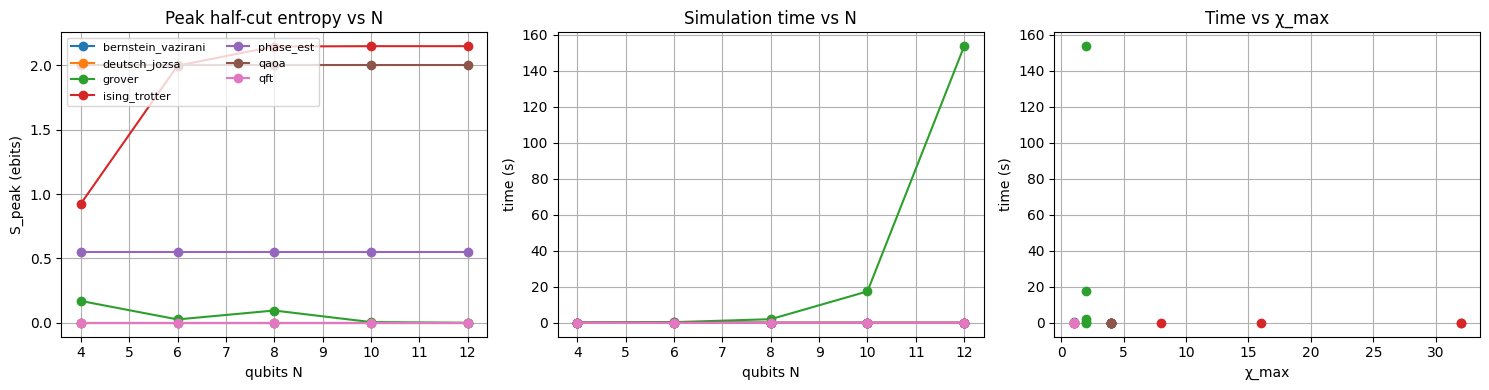

In [ ]:
import math, time, functools, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from typing import Dict, Callable, Tuple, List, Union
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import PhaseEstimation

def half_cut_entropy(snapshot: Union[Dict[str, List[np.ndarray]], Tuple[List, List[np.ndarray]], List[np.ndarray]]) -> Tuple[float, int]:
    singular_value_arrays: List[np.ndarray]

    if isinstance(snapshot, dict):
        singular_value_arrays = snapshot.get("lambda", [])
        if not singular_value_arrays and "final_mps" in snapshot and isinstance(snapshot["final_mps"], tuple) and len(snapshot["final_mps"]) == 2:
             singular_value_arrays = snapshot["final_mps"][1]
        elif not singular_value_arrays and "MPS" in snapshot and isinstance(snapshot["MPS"], tuple) and len(snapshot["MPS"]) == 2:
             singular_value_arrays = snapshot["MPS"][1]
    elif isinstance(snapshot, tuple) and len(snapshot) == 2:
        singular_value_arrays = snapshot[1]
    elif isinstance(snapshot, list):
        # If the snapshot is directly the list_of_lambda_data
        singular_value_arrays = snapshot
    else:
        return 0.0, 1

    if not singular_value_arrays:
        return 0.0, 1

    # Calculate chi_max: the maximum bond dimension across all cuts
    # Each element in singular_value_arrays is a 1D numpy array of singular values for a bond.
    # The length of this array is the bond dimension for that cut.
    chi_max_candidates = [len(s_values) for s_values in singular_value_arrays if isinstance(s_values, np.ndarray) and s_values.size > 0]

    if not chi_max_candidates:
        # This implies no bonds had singular values, or arrays were empty.
        # For N >= 2, this should mean a product state where chi=1 for all bonds.
        chi_max = 1
    else:
        chi_max = max(chi_max_candidates)
        # A bond dimension cannot be 0 for N > 1 if connections exist.
        # If max length was 0 (e.g. all arrays empty, which is odd), default to 1.
        if chi_max == 0:
             chi_max = 1

    # Select singular values for the middle cut
    # For N qubits, there are N-1 bonds.
    middle_cut_index = len(singular_value_arrays) // 2

    # Ensure the index is valid (it should be if singular_value_arrays is not empty)
    if not (0 <= middle_cut_index < len(singular_value_arrays)):
        # This indicates an issue with the structure of singular_value_arrays
        return 0.0, int(chi_max)

    schmidt_coeffs = np.array(singular_value_arrays[middle_cut_index])

    if schmidt_coeffs.size == 0:
        # Middle bond has dimension 0
        return 0.0, int(chi_max)

    # Probabilities are the squares of the Schmidt coefficients (singular values)
    # These lambda_i are such that sum(lambda_i^2) = 1
    probabilities = schmidt_coeffs**2

    # Calculate entanglement entropy: S = -sum(p_i * log2(p_i))
    # Filter out p_i = 0 to avoid log2(0) issues leading to NaN (0 * -inf)
    with np.errstate(divide='ignore', invalid='ignore'):
        # Create a boolean mask for probabilities greater than a small epsilon
        valid_mask = probabilities > 1e-15
        valid_probabilities = probabilities[valid_mask]

        if valid_probabilities.size == 0:
            S = 0.0
        else:
            # Calculate entropy only for non-zero probabilities
            S = -np.sum(valid_probabilities * np.log2(valid_probabilities))

    return S, int(chi_max)

def _grover_factory(n: int) -> QuantumCircuit:
    r = max(1, round((math.pi / 4) * math.sqrt(2 ** n)))
    qc = QuantumCircuit(n)
    qc.h(range(n))
    for _ in range(r):
        qc.h(n - 1)
        qc.mcx(list(range(n - 1)), n - 1)
        qc.h(n - 1)
        qc.h(range(n)); qc.x(range(n))
        qc.h(n - 1); qc.mcx(list(range(n - 1)), n - 1); qc.h(n - 1)
        qc.x(range(n)); qc.h(range(n))
    qc.barrier(label="Grover done")
    return qc

def _phase_est_factory(_: int) -> QuantumCircuit:
    theta = np.pi / 3
    u = QuantumCircuit(1)
    u.rz(2 * theta, 0)
    pe = PhaseEstimation(4, u)
    qc = QuantumCircuit(5)
    qc.compose(pe, qc.qubits, inplace=True)
    qc.barrier(label="QPE done")
    return qc

FACTORIES: Dict[str, Callable[[int], QuantumCircuit]] = {
    "grover": _grover_factory,
    "bernstein_vazirani": lambda n: bernstein_vazirani_circuit("1" * n),
    "deutsch_jozsa": functools.partial(deutsch_jozsa_circuit, oracle="balanced_parity"),
    "qft": qft_circuit,
    "phase_est": _phase_est_factory,
    "qaoa": lambda n: qaoa_maxcut_circuit([(i, (i + 1) % n) for i in range(n)], 1, [0.8], [0.7]),
    "ising_trotter": lambda n: trotter_ising_circuit(n, 1.0, 1.0, 2.0, 5),
}

BACKEND = AerSimulator(method="matrix_product_state")

def run_once(tag: str, n: int):
    qc = FACTORIES[tag](n)
    qc.save_matrix_product_state(label="final_mps")
    t0 = time.perf_counter()
    res = BACKEND.run(transpile(qc, BACKEND)).result()
    wall = time.perf_counter() - t0
    S, chi = half_cut_entropy(res.data(0)["final_mps"])
    return dict(alg=tag, N=n, runtime=wall, S_peak=S, chi_max=chi)

N_LIST, rows = [4, 6, 8, 10, 12], []
for alg in FACTORIES:
    print(f"\n▶ {alg}")
    for N in N_LIST:
        r = run_once(alg, N)
        print(f"  N={N:2d}  χ={r['chi_max']:<2d}  S={r['S_peak']:.3f}  t={r['runtime']:.3g}s")
        rows.append(r)

df = pd.DataFrame(rows)
display(df)
df.to_csv("entanglement_benchmark_results.csv", index=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for alg, grp in df.groupby("alg"):
    axs[0].plot(grp.N, grp.S_peak, "o-", label=alg)
    axs[1].plot(grp.N, grp.runtime, "o-", label=alg)
    axs[2].plot(grp.chi_max, grp.runtime, "o", label=alg)

axs[0].set(title="Peak half-cut entropy vs N", xlabel="qubits N", ylabel="S_peak (ebits)")
axs[1].set(title="Simulation time vs N", xlabel="qubits N", ylabel="time (s)")
axs[2].set(title="Time vs χ_max", xlabel="χ_max", ylabel="time (s)")
for ax in axs:
    ax.grid(True)
axs[0].legend(fontsize=8, ncol=2, loc="upper left")
plt.tight_layout()
plt.show()
